# Практика 2 часть 1. Переход от линейной регрессии к бинарной классификации (через регрессию)

В этом ноутбуке мы разберём, как **линейную регрессию** можно использовать для решения задачи **бинарной классификации** и почему у такого подхода есть ограничения.

Мы будем опираться на знания о линейной регрессии (МНК, градиентный спуск, `sklearn`) и шаг за шагом придём к идее линейного классификатора на основе регрессии.

**План ноутбука:**

1. Напоминание: линейная регрессия и функция потерь $\mathrm{MSE}$.
2. Построение синтетических данных для бинарной классификации.
3. Линейная модель как регрессия по меткам $y \in \{-1, +1\}$.
4. Превращение регрессионной модели в классификатор с порогом.
5. Визуализация разделяющей прямой (decision boundary).
6. Ограничения такого подхода и мотивация для логистической регрессии.


In [1]:
# Импорт библиотек
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Для воспроизводимости
np.random.seed(42)

# Настройки графиков (чуть крупнее шрифт)
plt.rcParams['figure.figsize'] = (6, 5)
plt.rcParams['font.size'] = 12

## 1. Напоминание: линейная регрессия

Рассмотрим линейную регрессию с двумя признаками:

$$
\hat{y} = w_0 + w_1 x_1 + w_2 x_2 = \mathbf{w}^\top \tilde{\mathbf{x}},
$$

где вектор признаков с добавленным свободным членом имеет вид

$$
\tilde{\mathbf{x}} = (1, x_1, x_2)^\top,
$$

а вектор параметров

$$
\mathbf{w} = (w_0, w_1, w_2)^\top.
$$

Мы минимизируем среднеквадратичную ошибку (Mean Squared Error, $\mathrm{MSE}$):

$$
\mathcal{L}(\mathbf{w}) = \frac{1}{n} \sum_{i=1}^n \bigl(y^{(i)} - \hat{y}^{(i)}\bigr)^2.
$$

В матричной форме решение методом наименьших квадратов (МНК) записывается как

$$
\hat{\mathbf{w}} = (X^\top X)^{-1} X^\top \mathbf{y},
$$

где:

- $X \in \mathbb{R}^{n \times 3}$ — матрица признаков с первым столбцом единиц,
- $\mathbf{y} \in \mathbb{R}^n$ — вектор целевой переменной.


### Небольшой пример: линейная регрессия в одномерном случае

Сгенерируем данные по простой линейной зависимости

$$
y = 2 x + 1 + \varepsilon,
$$

где $\varepsilon \sim \mathcal{N}(0, 1)$ — нормальный шум, и обучим модель `LinearRegression`.


Оценённые коэффициенты:
w_0 = 1.215
w_1 = 1.908


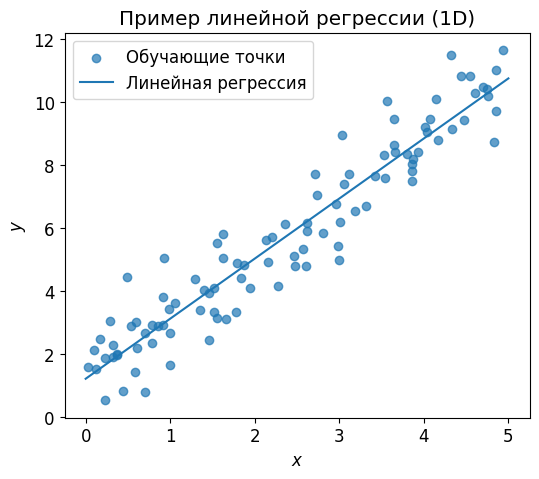

In [2]:
# Генерация одномерных данных для иллюстрации линейной регрессии
n_samples = 100
X_1d = 5 * np.random.rand(n_samples, 1)  # x ~ U(0, 5)
eps = np.random.randn(n_samples, 1)      # шум ~ N(0, 1)
y_1d = 2 * X_1d + 1 + eps                # y = 2x + 1 + шум

# Обучаем линейную регрессию
lin_reg_1d = LinearRegression()
lin_reg_1d.fit(X_1d, y_1d)

print("Оценённые коэффициенты:")
print(f"w_0 = {lin_reg_1d.intercept_[0]:.3f}")
print(f"w_1 = {lin_reg_1d.coef_[0, 0]:.3f}")

# Визуализируем
x_grid = np.linspace(0, 5, 100).reshape(-1, 1)
y_pred_1d = lin_reg_1d.predict(x_grid)

plt.scatter(X_1d, y_1d, alpha=0.7, label="Обучающие точки")
plt.plot(x_grid, y_pred_1d, label="Линейная регрессия")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.title("Пример линейной регрессии (1D)")
plt.show()

## 2. Построение синтетических данных для бинарной классификации

Теперь перейдём к **двумерным признакам** и **бинарным меткам**.

Пусть у нас есть скрытая линейная функция (линейный "скоринг"):

$$
z = w_0^{\ast} + w_1^{\ast} x_1 + w_2^{\ast} x_2.
$$

На её основе определим бинарную метку:

$$
y =
\begin{cases}
+1, & \text{если } z \ge 0, \\
-1, & \text{если } z < 0.
\end{cases}
$$

То есть данные заведомо **линейно разделимы** в пространстве признаков $(x_1, x_2)$.

Сгенерируем точки $\mathbf{x}^{(i)}$ и метки $y^{(i)}$ по такому правилу и отрисуем их на плоскости.


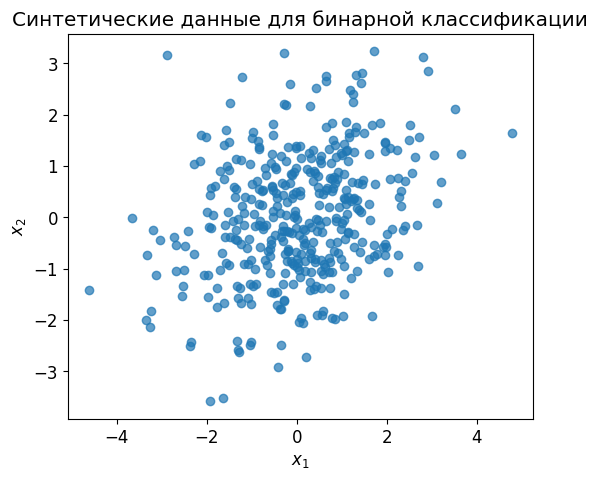

In [38]:
np.random.seed(42)

# Генерация данных для бинарной классификации на основе линейного правила
n_samples = 400

# Генерируем признаки x1, x2 из двумерного нормального распределения
mean = [0, 0]
cov = [[2.0, 0.5],
       [0.5, 1.5]]
X = np.random.multivariate_normal(mean, cov, size=n_samples)

# Визуализируем точки, окрашенные по классам
plt.scatter(X[:, 0], X[:, 1], alpha=0.7)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Синтетические данные для бинарной классификации")
plt.show()

Форма X: (400, 2)
Количество объектов класса -1: 236
Количество объектов класса 1: 164


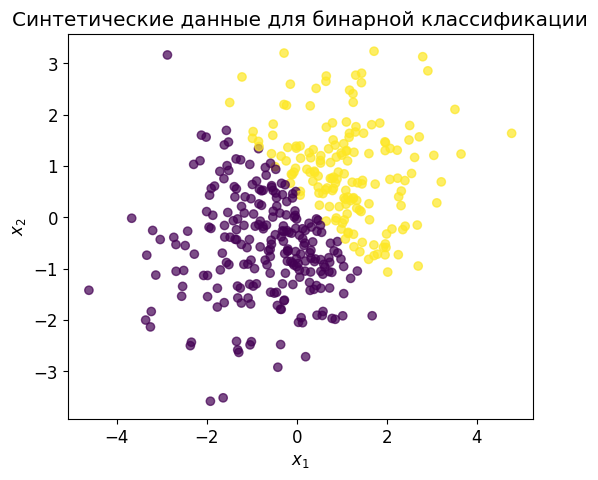

In [64]:
# Задаём "истинные" параметры линейного правила
w0_true = -0.5
w1_true = 1.0
w2_true = 1.0

# Вычисляем линейный скоринг z
z = w0_true + w1_true * X[:, 0] + w2_true * X[:, 1]

# Определяем метки: y = 1, если z >= 0, иначе -1
y = np.where(z >= 0, 1, -1)

print("Форма X:", X.shape)
print("Количество объектов класса -1:", np.sum(y == -1))
print("Количество объектов класса 1:", np.sum(y == 1))

# Визуализируем точки, окрашенные по классам
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.7)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Синтетические данные для бинарной классификации")
plt.show()

### Истинная разделяющая прямая

Наше линейное правило основано на знаке скалярного произведения

$$
z = w_0^{\ast} + w_1^{\ast} x_1 + w_2^{\ast} x_2.
$$

Граница между классами задаётся уравнением $z = 0$:

$$
w_0^{\ast} + w_1^{\ast} x_1 + w_2^{\ast} x_2 = 0.
$$

Решая относительно $x_2$, получаем:

$$
x_2 = -\frac{w_0^{\ast} + w_1^{\ast} x_1}{w_2^{\ast}}.
$$

Построим эту прямую поверх данных.


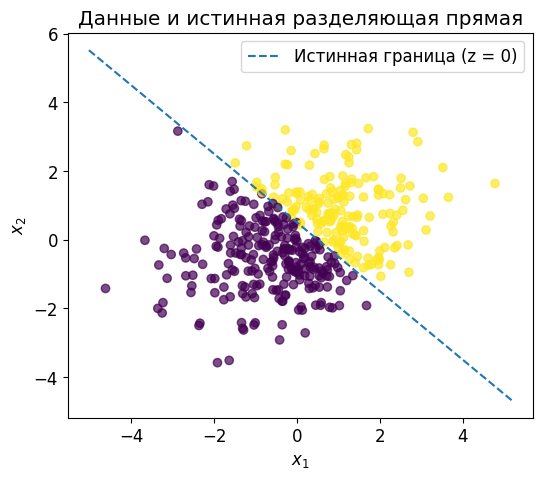

In [65]:
# Функция для отрисовки истинной разделяющей прямой
def plot_true_boundary(ax):
    x1_vals = np.linspace(X[:, 0].min() - 0.4, X[:, 0].max() + 0.4, 100)
    x2_vals = -(w0_true + w1_true * x1_vals) / w2_true
    ax.plot(x1_vals, x2_vals, linestyle="--", label="Истинная граница (z = 0)")

fig, ax = plt.subplots()
scatter = ax.scatter(X[:, 0], X[:, 1], c=y, alpha=0.7)
plot_true_boundary(ax)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_title("Данные и истинная разделяющая прямая")
ax.legend()
plt.show()

## 3. Линейная регрессия по меткам $y \in \{-1, +1\}$

Идея простого перехода от регрессии к классификации:

1. Считаем метки $y \in \{-1, +1\}$ **числовой** целевой переменной.
2. Обучаем **линейную регрессию**, минимизируя $\mathrm{MSE}$:
   $$
   \mathcal{L}(\mathbf{w}) = \frac{1}{n} \sum_{i=1}^n (y^{(i)} - \hat{y}^{(i)})^2.
   $$
3. Получаем предсказания $\hat{y}^{(i)}$ (вещественные числа).
4. Вводим **пороговое правило** классификации, например:

$$
\hat{y}_\text{class}^{(i)} =
\begin{cases}
+1, & \hat{y}^{(i)} \ge 0, \\
-1, & \hat{y}^{(i)} < 0.
\end{cases}
$$

Если мы перейдем от масштаба {-1; +1} к масштабу {0; 1}, то будем рассматривать выход линейной регрессии как приближённую "вероятность" класса $1$, а порог $0.5$ — как границу между классами.


In [66]:
X[:10]

array([[-0.56272579, -0.52516647],
       [-1.71102945,  0.8964596 ],
       [ 0.43700131, -0.03029863],
       [-2.48160328, -0.54915353],
       [ 0.29555426,  0.87872673],
       [ 0.86622333, -0.06214115],
       [ 0.78496781, -1.96945937],
       [ 2.55224039,  0.85599825],
       [ 1.1288909 ,  1.10084888],
       [ 1.98401151, -0.58569399]])

In [67]:
y[:10]

array([-1, -1, -1, -1,  1,  1, -1,  1,  1,  1])

In [68]:
# Обучим линейную регрессию на метках y \in {-1, +1}
lin_reg_cls = LinearRegression()
lin_reg_cls.fit(X, y)

w0_hat = lin_reg_cls.intercept_
w1_hat, w2_hat = lin_reg_cls.coef_

print("Оценённые коэффициенты линейной регрессии (классификация через регрессию):")
print(f"w_0 = {w0_hat:.3f}")
print(f"w_1 = {w1_hat:.3f}")
print(f"w_2 = {w2_hat:.3f}")

print(f"True coefs: {w0_true, w1_true, w2_true}")

# Предсказания регрессии
y_pred_reg = lin_reg_cls.predict(X)  # вещественные числа

print("\nПримеры предсказаний (первые 10):")
print(y_pred_reg[:10])

Оценённые коэффициенты линейной регрессии (классификация через регрессию):
w_0 = -0.202
w_1 = 0.371
w_2 = 0.365
True coefs: (-0.5, 1.0, 1.0)

Примеры предсказаний (первые 10):
[-0.60243368 -0.50986413 -0.05144921 -1.32248425  0.22748978  0.09605087
 -0.62935445  1.05573278  0.61736972  0.31954897]


## 4. Превращаем регрессию в классификатор: используем порог

Теперь введём правило классификации:

- если $\hat{y} \ge 0$, относим объект к классу $+1$,
- иначе — к классу $-1$.

Посчитаем качество классификации с помощью метрики **accuracy** (доля правильных ответов) и посмотрим на **confusion matrix**.


In [69]:
# Применим порог 0
y_pred_cls = np.where(y_pred_reg >= 0, 1, -1)
y_pred_cls[:10]

array([-1, -1, -1, -1,  1,  1, -1,  1,  1,  1])

In [70]:
# Оценим качество
acc = accuracy_score(y, y_pred_cls)
cm = confusion_matrix(y, y_pred_cls)

print(f"Accuracy (доля правильных ответов): {acc:.3f}")
print("Confusion matrix:")
print(cm)

print("\nПодробный отчёт:")
print(classification_report(y, y_pred_cls))

Accuracy (доля правильных ответов): 0.988
Confusion matrix:
[[236   0]
 [  5 159]]

Подробный отчёт:
              precision    recall  f1-score   support

          -1       0.98      1.00      0.99       236
           1       1.00      0.97      0.98       164

    accuracy                           0.99       400
   macro avg       0.99      0.98      0.99       400
weighted avg       0.99      0.99      0.99       400



## 5. Визуализация разделяющей прямой, полученной из регрессии

В случае линейной регрессии с двумя признаками мы имеем модель

$$
\hat{y} = w_0 + w_1 x_1 + w_2 x_2.
$$

Порог $0$ задаёт уравнение разделяющей прямой:

$$
w_0 + w_1 x_1 + w_2 x_2 = 0.
$$

Решив относительно $x_2$, получаем:

$$
x_2 = -\frac{w_0 + w_1 x_1}{w_2}.
$$

Построим эту прямую и сравним с истинной границей $z = 0$.


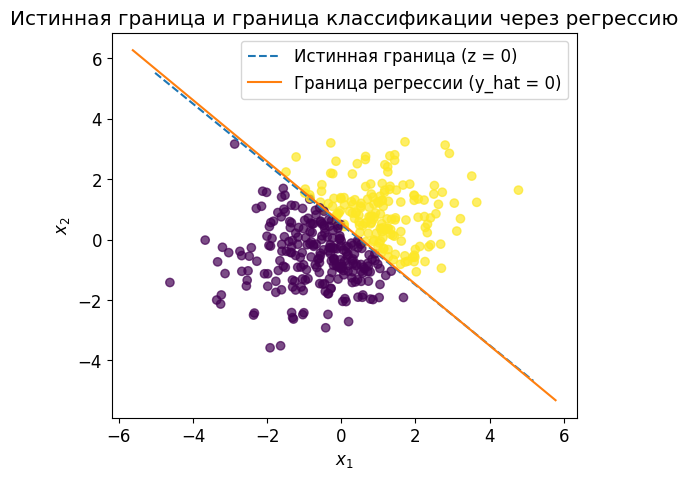

In [71]:
# Функция для отрисовки разделяющей прямой из регрессионной модели
def plot_regression_boundary(ax):
    x1_vals = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100)
    # w0 + w1 * x1 + w2 * x2 = 0  =>  x2 = -(w0 + w1 * x1) / w2
    x2_vals = -(w0_hat + w1_hat * x1_vals) / w2_hat
    ax.plot(x1_vals, x2_vals, label="Граница регрессии (y_hat = 0)")

fig, ax = plt.subplots()
scatter = ax.scatter(X[:, 0], X[:, 1], c=y, alpha=0.7)
plot_true_boundary(ax)
plot_regression_boundary(ax)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_title("Истинная граница и граница классификации через регрессию")
ax.legend()
plt.show()

## 6. Что не так с классификацией через линейную регрессию?

С одной стороны, подход "классификация через регрессию" выглядит привлекательно:

- мы используем знакомую модель;
- решение можно получить аналитически (МНК);
- порог $0$ даёт разделяющую прямую.

Однако у такого подхода есть важные **ограничения**.

### 6.1. Выходные значения не ограничены интервалом $[-1, +1]$

Линейная регрессия может выдавать значения $\hat{y}$ существенно меньше $-1$ или больше $+1$. И вообще мы хотели бы интерпретировать их как "псевдо-вероятности".

Посмотрим на распределение предсказаний $\hat{y}$:


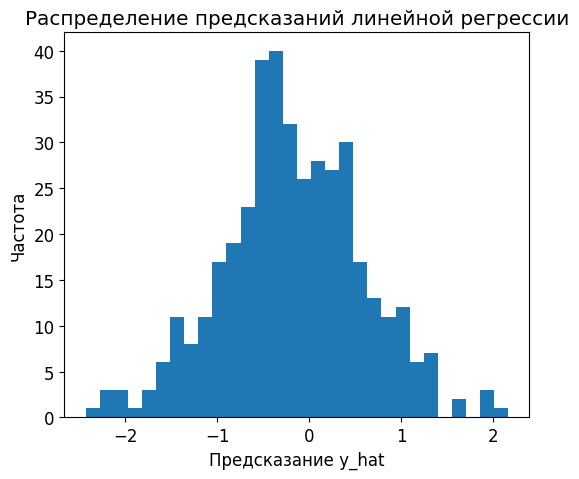

Минимальное предсказание: -2.4335090255000678
Максимальное предсказание: 2.1657831543294765


In [72]:
# Гистограмма предсказаний регрессии
plt.hist(y_pred_reg, bins=30)
plt.xlabel("Предсказание y_hat")
plt.ylabel("Частота")
plt.title("Распределение предсказаний линейной регрессии")
plt.show()

print("Минимальное предсказание:", np.min(y_pred_reg))
print("Максимальное предсказание:", np.max(y_pred_reg))

Часто можно увидеть предсказания $\hat{y} < -1$ или $\hat{y} > 1$, что плохо согласуется с вероятностной интерпретацией.

### 6.2. Функция потерь $\mathrm{MSE}$ не оптимальна для классификации

При классификации нас больше интересует **правильный знак/класс**, а не точное приближение численных значений $-1$ и $1$.

Функция потерь $\mathrm{MSE}$

$$
\mathrm{MSE} = \frac{1}{n} \sum_{i=1}^n (y^{(i)} - \hat{y}^{(i)})^2
$$

считает большие квадратичные штрафы за "далёкость" от $-1$ и $1$, но не учитывает:

- асимметрию важности ошибок (ложноположительные/ложноотрицательные),
- вероятностную интерпретацию (логарифмическая функция потерь логистической регрессии учитывает именно вероятности классов).

### 6.3. Чувствительность к выбросам и шуму

Если добавить в данные несколько точек с "аномальными" метками, линейная регрессия будет стараться подогнать **численные значения** $-1$ и $1$ для всех объектов, и разделяющая граница может сместиться.

С точки зрения классификации нам важнее **граница между классами**, а не точные численные значения выходов.

---

Все эти проблемы мотивируют переход к более подходящей модели для бинарной классификации — **логистической регрессии**, где:

- выход модели ограничен интервалом $[0, 1]$ с помощью сигмоиды,
- используется специфическая функция потерь (логистическая, или binary cross-entropy),
- предсказания интерпретируются как вероятности класса $1$.

Это будет темой следующего ноутбука.


## 7. Метрики качества в бинарной классификации

В бинарной классификации есть два класса: **позитивный** (обычно `1`) и **негативный** (`0`).  
Чтобы корректно оценить качество модели, вводятся базовые типы предсказаний и ошибок.

---

### 1. Базовые понятия: TP, FP, FN, TN

Каждый объект классификации может быть предсказан верно или неверно. Возможны четыре варианта:

|                          | Истинный класс = 1 | Истинный класс = 0 |
|--------------------------|--------------------|---------------------|
| **Предсказали 1**        | **TP** — True Positive      | **FP** — False Positive |
| **Предсказали 0**        | **FN** — False Negative     | **TN** — True Negative  |

Интерпретации:

- **TP** — модель правильно обнаружила объект класса 1.  
- **TN** — модель правильно отвергла объект класса 0.  
- **FP** — ложная тревога: модель ошибочно выдала класс 1.  
- **FN** — пропуск: модель ошибочно выдала класс 0 там, где должен быть класс 1.

---

### 2. Accuracy — доля правильных ответов

Accuracy показывает, какую часть объектов модель предсказала правильно:

$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}.
$$

Плюсы:
- простая и понятная метрика.

Минусы:
- плохо работает при несбалансированных классах: можно получить высокую accuracy, вообще игнорируя редкий класс.

---

### 3. Precision — точность среди предсказанных позитивов

Precision отвечает на вопрос:  
*“Если модель выдала класс 1, насколько часто она права?”*

$$
\text{Precision} = \frac{TP}{TP + FP}.
$$

Высокий precision означает мало ложных тревог (FP).

Пример: медицинский тест, где важно **не давать ложных диагнозов**.

---

### 4. Recall — полнота среди истинных позитивов

Recall отвечает на вопрос:  
*“Какую долю объектов класса 1 мы действительно нашли?”*

$$
\text{Recall} = \frac{TP}{TP + FN}.
$$

Высокий recall означает мало пропущенных позитивных объектов (FN).

Пример: поиск мошенничества, где важно **не пропустить** опасную транзакцию.

---

### 5. F1-score — гармоническое среднее Precision и Recall

F1 балансирует две метрики, особенно полезен в задачах с несбалансированными классами:

$$
\text{F1} = 
2 \cdot \frac{\text{Precision} \cdot \text{Recall}}
{\text{Precision} + \text{Recall}}.
$$

Свойства:

- высокий F1 возможен только тогда, когда **и precision, и recall высокие одновременно**;
- если одна метрика сильно мала — F1 тоже будет низким.

---

### 6. Когда какую метрику использовать?

- **Accuracy** — только когда классы сбалансированы и ошибки одинаково критичны.  
- **Precision** — когда FP очень нежелательны (ложные тревоги).  
- **Recall** — когда FN очень нежелательны (пропуски).  
- **F1-score** — когда важен общий баланс качества; стандартная метрика для несбалансированных задач.

---

### 7. Confusion matrix (матрица ошибок)

Матрица ошибок — способ визуально представить TP, FP, FN, TN:

|               | Предсказано 0 | Предсказано 1 |
|---------------|---------------|---------------|
| **Истинный 0** | TN            | FP            |
| **Истинный 1** | FN            | TP            |

По матрице удобно анализировать, какие ошибки модель делает чаще всего.

---

### Итог

Бинарные метрики образуют основу для всех будущих многоклассовых метрик:  
в многоклассовом случае каждая метрика считается **по каждому классу** как “класс k против всех остальных”, а затем агрегируется.


=== Заданные значения ===
TN = 50, FP = 10, FN = 5, TP = 20

=== Метрики ===
Accuracy           : 0.8235
Precision (class 1): 0.6667
Recall    (class 1): 0.8000
F1-score  (class 1): 0.7273
F1_macro    (total): 0.7984

=== Confusion matrix ===
[[50 10]
 [ 5 20]]

=== classification_report ===
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        60
           1       0.67      0.80      0.73        25

    accuracy                           0.82        85
   macro avg       0.79      0.82      0.80        85
weighted avg       0.84      0.82      0.83        85



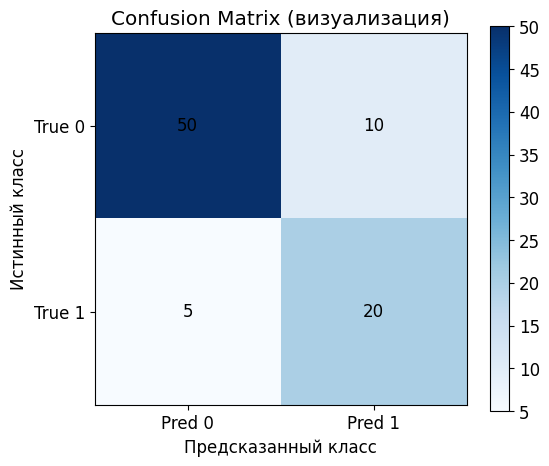

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)

# =========================================================
# Функция, которая по вручную заданным TP/FP/FN/TN
# создаёт искусственные y_true и y_pred и считает метрики
# =========================================================
def test_metrics(TN, FP, FN, TP):
    """
    Создаём выборку, полностью соответствующую вручную заданной confusion matrix.
    Затем считаем все основные метрики.
    """

    # -------------------------
    # 1) Воссоздаём выборку
    # -------------------------
    # Истинные классы
    y_true = (
        [0] * TN +       # TN: истинный 0, предсказан 0
        [0] * FP +       # FP: истинный 0, предсказан 1
        [1] * FN +       # FN: истинный 1, предсказан 0
        [1] * TP         # TP: истинный 1, предсказан 1
    )

    # Предсказанные классы
    y_pred = (
        [0] * TN +       # TN: предсказан 0
        [1] * FP +       # FP: предсказан 1
        [0] * FN +       # FN: предсказан 0
        [1] * TP         # TP: предсказан 1
    )

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # -------------------------
    # 2) Считаем метрики
    # -------------------------
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    f1_total = f1_score(y_true, y_pred, average="macro")
    

    print("=== Заданные значения ===")
    print(f"TN = {TN}, FP = {FP}, FN = {FN}, TP = {TP}")
    print("\n=== Метрики ===")
    print(f"Accuracy           : {acc:.4f}")
    print(f"Precision (class 1): {prec:.4f}")
    print(f"Recall    (class 1): {rec:.4f}")
    print(f"F1-score  (class 1): {f1:.4f}")
    print(f"F1_macro    (total): {f1_total:.4f}")

    # -------------------------
    # 3) Confusion matrix
    # -------------------------
    cm = confusion_matrix(y_true, y_pred)
    print("\n=== Confusion matrix ===")
    print(cm)

    # -------------------------
    # 4) classification_report
    # -------------------------
    print("\n=== classification_report ===")
    print(classification_report(y_true, y_pred, zero_division=0))

    # -------------------------
    # 5) Визуализация матрицы
    # -------------------------
    plt.imshow(cm, cmap="Blues")
    plt.title("Confusion Matrix (визуализация)")
    plt.colorbar()
    plt.xticks([0,1], ["Pred 0", "Pred 1"])
    plt.yticks([0,1], ["True 0", "True 1"])
    plt.xlabel("Предсказанный класс")
    plt.ylabel("Истинный класс")

    # подписи внутри клеток
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha='center', va='center', color='black', fontsize=12)

    plt.show()


# =========================================================
# Пример вызова
# Здесь можно менять TN, FP, FN, TP и смотреть, что произойдёт
# =========================================================
test_metrics(
    TN=50,   # Задаём TN
    FP=10,   # Ложные срабатывания
    FN=5,    # Пропуски
    TP=20    # Верные позитивы
)


## 8. Краткое резюме

В этом ноутбуке мы:

1. Вспомнили линейную регрессию и функцию потерь $\mathrm{MSE}$.
2. Сгенерировали синтетический датасет для бинарной классификации с линейной границей.
3. Обучили линейную регрессию по меткам $y \in \{-1, 1\}$.
4. Превратили регрессионную модель в классификатор с порогом $0$ и оценили качество.
5. Визуализировали разделяющие прямые: истинную и полученную из регрессии.
6. Обсудили ограничения подхода "классификация через регрессию" и мотивацию для логистической регрессии.

Дальше логично перейти к **логистической регрессии**, где модель специально сконструирована под задачи бинарной классификации и даёт выходы, интерпретируемые как вероятности.
